# VT2

In [94]:
# Import of Packages
import numpy as np
import pandas as pd
import statistics as st
import time

# Import of Packages for Functions
import math
import matplotlib.pyplot as plt
import sys

# Importing the Functions File
import Functions_VT2 as fn

# Start of Timer to Measure Runtime
start_time = time.time()

## Scenario Generation

In [95]:
# Demand at t0
Dt0 = 22561132
# Steptime in Years
dt = 1
# Time Horizon of Forecasts in Steptime
Fth = 20
# Number of Forecasts
Forecasts = 1

# Parameters
mu = 0.042754330256447565
sigma = 0.05813761525452841

### Plotting the Scenarios

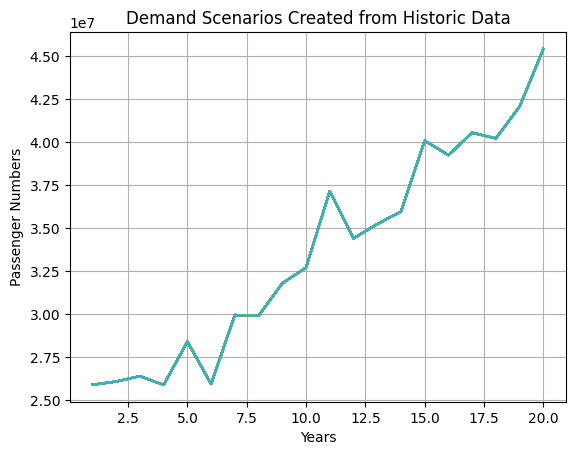

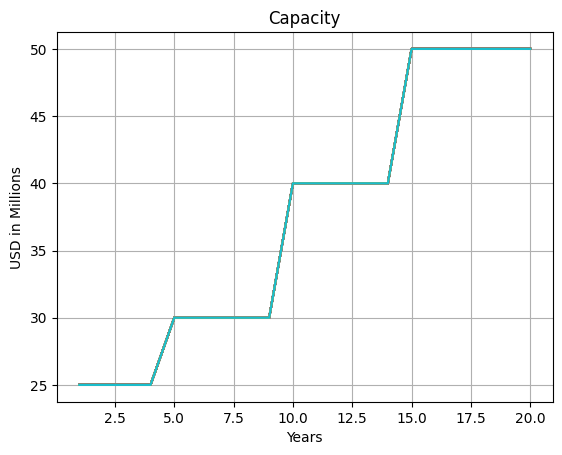

<Figure size 640x480 with 0 Axes>

In [96]:
# Calling the Scenario Creation Function
Scenarios = fn.generate_scenarios(mu, sigma, Dt0, dt, Fth, Forecasts)

# Round values up for further Calculation
D = np.ceil(Scenarios)
# print(D)


# Calling the Scenario Plotting Function
fn.Scenario_plot(
    Scenarios,
    Fth,
    True,
    "Demand Scenarios Created from Historic Data",
    "Passenger Numbers",
    30,
)

# Need to define Capacity first!!

# # Calling the Scenario Plotting Function
# fn.Scenario_plot(
#     K_rounded,
#     Fth,
#     True,
#     "Capacity",
#     "USD in Millions",
#     30,
# )

# print(np.shape(Scenarios))
# print(Scenarios)

Geometric Brownian motion Formula

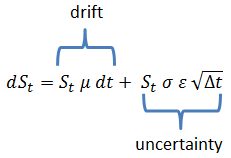

## Estimation of Dockstand Demand

In [97]:
# Percentage of Pax using Dock Stands rather than Bus Gates
p_dock = 0.8
# Percentage of Pax travelling within Schengen Area
p_schengen = 0.8
# Percentage of Pax travelling from Dock
p_Dok_A_B = 0.5
# average number of passengers carried per air traffic movement
PAXATM = 114

# Demand at design Hour
D_per_hour = D / (365 * 17)

# Contact Stand Demand (ZRH has 75, but not all can be used at once)
# Dock A has 17 Contact and 16 Bus Gates

d = (D_per_hour * p_dock * p_schengen * p_Dok_A_B) / PAXATM

# print("Contact Stand demad d: ", d)

### Plotting the Dockstand demand

In [98]:
# # Calling the Scenario Plotting Function
# fn.Scenario_plot(
#     d,
#     Fth,
#     True,
#     "Dockstand Demand Terminal A at ZRH",
#     "Number of Dock Stands",
#     30,
# )

## Calulation of the NPV
 #Check if greater, less, equal is correct!!!

In [99]:
# # Objective function (NPV)
# def NPV_Genetic(K):
#     t = np.arange(0, Fth, dt)
#     delta_K0 = np.diff(K)
#     delta_K = np.insert(delta_K0, 0, 0)
#     diff = K - D_rounded
#     Revenue = K * r_K + D_rounded * r_D
#     Cost = K * co_K + D_rounded * co_D + ci_K * delta_K + pc * abs(diff)
#     Profit = Revenue - Cost
#     Discount = 1 / ((1 - discount) ** t)
#     NPV = np.sum(Profit * Discount)
#     return -NPV  # We use negative NPV to maximize


#     # Calculate the Difference Matrix
#     diff = K - D
#     # Initialize an array to store Revenue for each value
#     Revenue = np.zeros(D.shape)
#     # Initialize an array to store NPV for each row
#     NPV = np.zeros(D.shape[0])

#     # Create an Index Matrix with the Condition for Overcapacity
#     greater_than_zero = np.greater(diff, 0).astype(int)
#     # Create an Index Matrix with the Condition for Undercapacity
#     less_than_or_equal_zero = np.less_equal(diff, 0).astype(int)

#     # Calculation of the Revenue with in the Overcapacity Condition
#     Revenue1 = greater_than_zero * (
#         (D * r_K_rent + K * r_K + th * D * r_D)
#         - ((K - D) * r_K_rent + (K - D) * th * r_K)
#    # Calculation of the Revenue with in the Undercapacity Condition
#    Revenue2 = less_than_or_equal_zero * (K * r_K_rent + K * r_K + th * D * r_D)
#    # Combine the two Revenue Matrices
#    Revenue = Revenue1 + Revenue2


def Revenue(K, D, r_k, r_K_rent, r_D):
    # Check if greater, less, equal is correct!!!
    diff = K - D
    greater_zero = np.greater(diff, 0).astype(int)
    less_equal_zero = np.less_equal(diff, 0).astype(int)

    # if Overcapacity only Demand will be sold
    rev_overcapacity = greater_zero * (D * r_k + D * r_K_rent + D * r_D)

    # if Undercapacity only available Capacity can be sold
    rev_undercapacity = less_equal_zero * (K * r_k + K * r_K_rent + K * r_D)

    Total_Revenue = rev_overcapacity + rev_undercapacity
    return Total_Revenue



def Cost(K, D, d, EoS, ci_K, delta_K0, h, co_D, co_K):
    # Creation of a Capacity Change Vector
    delta_K0 = np.diff(K)
    # Setting the initial Value of the Change Vector to Zero
    delta_K = np.insert(delta_K0, 0, 0)


    # Penalty Cost Overcapacity
    pc_over = 0.1
    # Penalty Cost Undercapacity
    pc_under = 0.1
    # Calculate the Difference Matrix
    diff = K - D
    # Create an Index Matrix with the Condition for undercapacity
    cos_overcapacity = np.greater(diff, 0).astype(int)
    cos_undercapacity = np.less(diff, 0).astype(int)
    cos_equalcapacity = np.equal(diff, 0).astype(int)

    Total_Cost = (
        ((ci_K * np.abs(delta_K) ** EoS) / h)
        + cos_undercapacity * (pc_under + (co_D * K + co_K * K))
        + cos_overcapacity * (pc_over + (co_D * D + co_K * D))
        + cos_equalcapacity * (co_D * D + co_K * K)
    )


    return Total_Cost



def NPV_calculation(Revenue, Cost, discount):
    t = np.arange(0, Fth, dt)
    Profit = Revenue - Cost
    Discount = 1 / (1 + discount) ** t
    Present_value = Profit * Discount
    NPV = np.sum(Present_value, axis=1)
    return NPV

In [100]:
th = 1000000  # Throughput Capacity per Unit of Capacity
r_D = 1  # Revenues per Unit of Demand per Period
r_K = 1  # Revenues per Unit of Capacity per Period
r_K_rent = 0.5  # Rental Revenues per Unit of Capacity per Period
co_K = 0.5  # Operational costs per unit of capacity per period
co_D = 0.5  # Operational cost per unit of demand per period
ci_K = 3  # Installation cost per unit of capacity
discount = 0.05  # Discount factor
EoS = 0.85  # EoS factor
delta_K0 = 0
h = 1

# Definition of a Capacity Vector
K_rounded = np.array(
    [25, 25, 25, 25, 30, 30, 30, 30, 30, 40, 40, 40, 40, 40, 50, 50, 50, 50, 50, 50]
)

D_rounded = np.ceil(D / 1000000)

Rev = Revenue(K_rounded, D_rounded, r_K, r_K_rent, r_D)

Cos = Cost(K_rounded, D_rounded, d, EoS, ci_K, delta_K0, h, co_D, co_K)
# print(Cos)

NPV1 = NPV_calculation(Rev, Cos, discount)
print(NPV1)

ENPV = sum(NPV1)
# print("ENPV: ", ENPV)

[592.05018481]


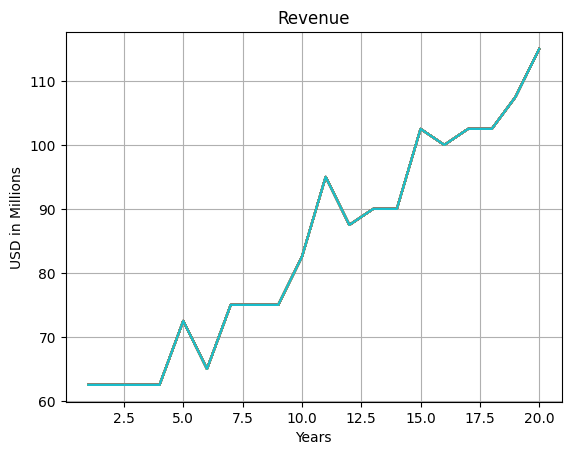

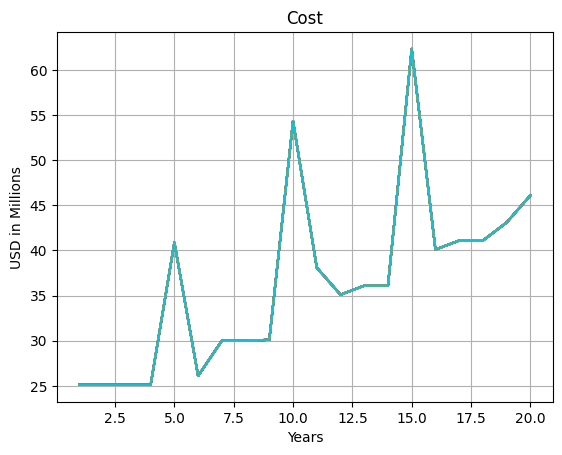

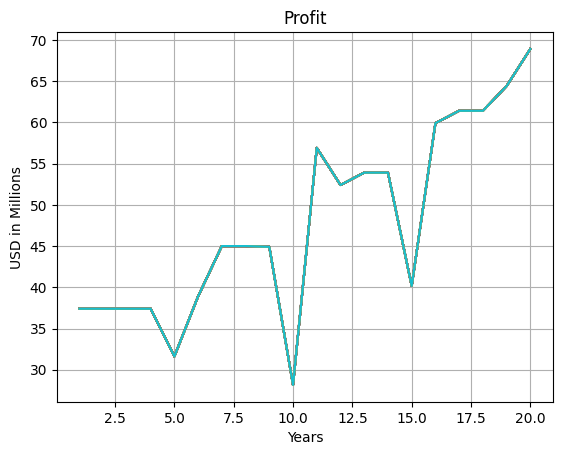

<Figure size 640x480 with 0 Axes>

In [101]:
# Calling the Scenario Plotting Function
fn.Scenario_plot(
    Rev,
    Fth,
    True,
    "Revenue",
    "USD in Millions",
    30,
)

# Calling the Scenario Plotting Function
fn.Scenario_plot(
    Cos,
    Fth,
    True,
    "Cost",
    "USD in Millions",
    30,
)

# Calling the Scenario Plotting Function
fn.Scenario_plot(
    Rev - Cos,
    Fth,
    True,
    "Profit",
    "USD in Millions",
    30,
)

In [102]:
K_optimized = np.array(
    [
        25,
        26,
        27,
        26,
        29,
        26,
        30,
        30,
        32,
        33,
        37,
        35,
        36,
        36,
        40,
        40,
        41,
        41,
        42,
        25,
    ]
)

D_rounded = np.ceil(D / 1000000)

Rev = Revenue(K_optimized, D_rounded, r_K, r_K_rent, r_D)

Cos = Cost(K_optimized, D_rounded, d, EoS, ci_K, delta_K0, h, co_D, co_K)
# print(Cos)

NPV1 = NPV_calculation(Rev, Cos, discount)
print(NPV1)

ENPV = sum(NPV1)
# print("ENPV: ", ENPV)

[554.79284783]


### Stopping the Runtime

In [103]:
end_time = time.time()

# Calculate the Total Runtime
total_run_time = end_time - start_time

# Display the Total Runtime
print("Total Runtime =", total_run_time)

Total Runtime = 1.5260810852050781
